In [1]:
import pandas as pd
import numpy as np
import stan
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

In [2]:
import os
os.environ['CMDSTAN'] = '/Users/indiaermacora/.cmdstan/cmdstan-2.31.0'

In [3]:
from cmdstanpy import CmdStanModel, set_cmdstan_path, cmdstan_path
import arviz as az
import os

/Users/indiaermacora/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
cmdstan_path()

'/Users/indiaermacora/.cmdstan/cmdstan-2.31.0'

In [5]:
nugget = pd.read_csv('stan/nugget_to_python.csv', sep = ";")
dati_covariates = pd.read_csv('stan/covariates.csv', sep = ";")
dat_complete_log = pd.read_csv('stan/dat_complete_log_to_python.csv', sep = ";")
ind_pres=pd.read_csv('stan/ind_pres_to_python.csv', sep = ";")
ind_miss=pd.read_csv('stan/ind_miss_to_python.csv', sep = ";")
lat_long=pd.read_csv('stan/lat_long_2_to_python.csv', sep = ";")
dat_2017_log=pd.read_csv('stan/log_dati_2017.csv', sep = ";")

In [6]:
dat_complete_log.mean()

x    2.760721
dtype: float64

In [7]:
matrix_dati_covariates=np.matrix(dati_covariates)
dat_2017_log_matrix= np.matrix(dat_2017_log, dtype=float)
dat_2017_log_matrix_centered= dat_2017_log_matrix-dat_complete_log.mean()[0]

quota= np.array (matrix_dati_covariates[0,:], dtype=int)
quota_norm = ((quota-quota.mean())/quota.std())

area_dummies = pd.get_dummies(dati_covariates.iloc[1, :])
zona_dummies = pd.get_dummies(dati_covariates.iloc[2, :])

all_cov = np.matrix(pd.concat([area_dummies.Urbano, area_dummies.Suburbano, zona_dummies.Fondo, zona_dummies.Traffico],axis=1),dtype=int)
all_cov = np.concatenate((np.transpose(quota_norm),all_cov),axis=1)

ind_miss = np.array(ind_miss)
ind_pres = np.array(ind_pres)
dat_complete_log= np.array(dat_complete_log, dtype=float)
dat_complete_log_centered= dat_complete_log- dat_complete_log.mean() 

nugget_mat = np.matrix(nugget, dtype=float)
coord = np.matrix( pd.concat([lat_long.Lat, lat_long.Long], axis=1) )

In [11]:
#all stations

arima_model = """

data {
  int<lower=0> num_giorni;
  int<lower=0> num_stazioni;
  
  matrix[num_stazioni, 5] covariates;
  
  int Ncomp; // Number of non-missing values
  int  Nmiss; // Number of missing values
  vector [Ncomp] dat_complete;
  int ind_pres[Ncomp, 2];
  int ind_miss[Nmiss, 2];

  matrix[num_stazioni,num_stazioni] dist_w;  //distance matrix
  real phi;
  matrix[6,num_stazioni] y_2017; 
}


parameters {
  real phi1;
  real phi2;
  real phi3;
  real theta1;
  real theta2;
  real<lower=0> sigma;
  
  real beta_0;
  vector[5] beta_cov;
  
  vector [Nmiss] dat_miss;

  real<lower=0> a;
  vector[num_stazioni] w;
} 

transformed parameters{

  matrix[num_giorni, num_stazioni] y;
  matrix[num_stazioni, num_stazioni] cov_w;
  
  vector[num_giorni] epsilon[num_stazioni]; // forecast errors
  vector[num_giorni] y_hat[num_stazioni]; // predicted values
  vector[num_giorni] output[num_stazioni]; // predicted values
  
  vector[2] epsilon_2017[num_stazioni]; // forecast errors
  vector[2] y_hat_2017[num_stazioni]; // predicted values
  
  
  //NA
  for (i in 1:Ncomp) {
    y[ind_pres[i,1], ind_pres[i,2]] =  dat_complete[i];
  }
  for(i in 1:Nmiss) {
    y[ind_miss[i,1], ind_miss[i,2]] = dat_miss[i];
    }
  
  //spatial residuals 
  cov_w = a*exp(-phi*dist_w);


  // Loop over the time series
  for (n in 1:num_stazioni) {
    
    //y_2017 [26, 27, 28, 29, 30, 31]
    
    //30 dicembre 2017
    y_hat_2017[n][1] = (1+phi1) * y_2017[4,n] + (phi2-phi1) * y_2017[3,n] + (phi3-phi2) * y_2017[2,n] -phi3*y_2017[1,n] + beta_0 + covariates[n,:] * beta_cov;
    epsilon_2017[n][1] = y_2017[5,n] - y_hat_2017[n][1];
    
    //31 dicembre 2017
    y_hat_2017[n][2] = (1+phi1) * y_2017[5,n] + (phi2-phi1) * y_2017[4,n] + (phi3-phi2) * y_2017[3,n] -phi3*y_2017[2,n] + theta1 * epsilon_2017[n][1] + beta_0 + covariates[n,:] * beta_cov;
    epsilon_2017[n][2] = y_2017[6,n] - y_hat_2017[n][2];
    
    //1 gennaio 2018
    y_hat[n][1] = (1+phi1) * y_2017[6,n] + (phi2-phi1) * y_2017[5,n] + (phi3-phi2) * y_2017[4,n] -phi3*y_2017[3,n] + theta1 * epsilon_2017[n][2] + theta2 * epsilon_2017[n][1] + beta_0 + covariates[n,:] * beta_cov;
    epsilon[n][1] = y[1,n] - y_hat[n][1];
    
    y_hat[n][2] = (1+phi1) * y[1,n] + (phi2-phi1) * y_2017[6,n] + (phi3-phi2) * y_2017[5,n] -phi3*y_2017[4,n] + theta1 * epsilon[n][1] + theta2 * epsilon_2017[n][2] + beta_0 + covariates[n,:] * beta_cov;
    epsilon[n][2] = y[2,n] - y_hat[n][2];
      
    y_hat[n][3] = (1+phi1) * y[2,n] + (phi2-phi1) * y[1,n] + (phi3-phi2) * y_2017[6,n] -phi3*y_2017[5,n] + theta1 * epsilon[n][2] + theta2 * epsilon[n][1] + beta_0 + covariates[n,:] * beta_cov;
    epsilon[n][3] = y[3,n] - y_hat[n][3];
    
    y_hat[n][4] = (1+phi1) * y[3,n] + (phi2-phi1) * y[2,n] + (phi3-phi2) * y[1,n] -phi3*y_2017[6,n] + theta1 * epsilon[n][3] + theta2 * epsilon[n][2] + beta_0 + covariates[n,:] * beta_cov;
    epsilon[n][4] = y[4,n] - y_hat[n][4];
    
    
    output[n][1] = y_hat[n][1] + w[n];
    output[n][2] = y_hat[n][2] + w[n];
    output[n][3] = y_hat[n][3] + w[n];
    output[n][4] = y_hat[n][4] + w[n];
    
    // Loop over the time points and calculate the forecast errors and predicted values
    for (t in 5:num_giorni) {
      y_hat[n][t] = (1+phi1) * y[t-1,n] + (phi2-phi1) * y[t-2,n] + (phi3-phi2) * y[t-3,n] -phi3*y[t-4,n] + theta1 * epsilon[n][t-1] + theta2 * epsilon[n][t-2] + beta_0 + covariates[n,:] * beta_cov;
      epsilon[n][t] = y[t,n] - y_hat[n][t];
      output[n][t] = y_hat[n][t] + w[n];
    }
    
  }

}

model {

  phi1 ~ normal(0,1); 
  phi2 ~ normal(0,1);
  phi3 ~ normal(0,1);
  theta1 ~ normal(0,1);
  theta2 ~ normal(0,1);
  
  sigma ~ inv_gamma(3,2);
  
  beta_0 ~ normal(0, 1);
  beta_cov ~ normal(0, 1);
  
  a ~ inv_gamma(3,2);
  w ~ multi_normal(rep_vector(0,num_stazioni),cov_w);
  
  // Likelihood function
  for (n in 1: num_stazioni) {
    y[:,n] ~ normal(output[n][:], sqrt(sigma)); 
  }

}

generated quantities {
  matrix[num_giorni, num_stazioni] log_lik; // matrix to store the predicted values
  for (i in 1:num_giorni) {
    for (j in 1:num_stazioni) {
      // compute the predicted value at each element of y
      log_lik[i, j] = normal_lpdf(y[i,j] | output[j][i], sqrt(sigma));
    }
  } 
}
"""

stan_file = "./arima.stan"

with open(stan_file, "w") as f:
    print(arima_model, file=f)

arima = CmdStanModel(stan_file=stan_file)

20:18:28 - cmdstanpy - INFO - compiling stan file /Users/indiaermacora/PycharmProjects/pythonProject/arima.stan to exe file /Users/indiaermacora/PycharmProjects/pythonProject/arima
20:18:40 - cmdstanpy - INFO - compiled model executable: /Users/indiaermacora/PycharmProjects/pythonProject/arima
20:18:40 - cmdstanpy - WARNING - Stan compiler has produced 7 warnings:
20:18:40 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/Users/indiaermacora/PycharmProjects/pythonProject/arima.hpp /Users/indiaermacora/PycharmProjects/pythonProject/arima.stan
Warning in '/Users/indiaermacora/PycharmProjects/pythonProject/arima.stan', line 12, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/Users/indiaermacora/PycharmProjects/pythonProject/arima.stan', 

In [13]:
reg_data= {
  "num_giorni" : 365,
  "num_stazioni" : 62,
  "covariates": all_cov,
  "Ncomp": 21440,
  "Nmiss": 1190,
  "dat_complete" : dat_complete_log[:,0],
  "ind_pres" : ind_pres,
  "ind_miss" : ind_miss, 
  "dist_w": nugget_mat, 
  "phi": 0.008,
  "y_2017": dat_2017_log_matrix
}

fit = arima.sample(data=reg_data, chains=4, parallel_chains=4, 
                iter_warmup=1000, iter_sampling=1000, show_progress=True, show_console=True)
arima_az = az.from_cmdstanpy(fit)

20:19:24 - cmdstanpy - INFO - Chain [1] start processing
20:19:24 - cmdstanpy - INFO - Chain [2] start processing
20:19:24 - cmdstanpy - INFO - Chain [3] start processing
20:19:24 - cmdstanpy - INFO - Chain [4] start processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 1000 (Default)
Chain [1] num_warmup = 1000 (Default)
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /var/folders/bk/7lgnnh611y3190f1_3m0wp1w0000gn/T/tmplbiwx1eo/sgtukdj_.json
Chain [1] init = 2 (Default)
Chain [1] random


21:51:58 - cmdstanpy - INFO - Chain [4] done processing


Chain [4] 
Chain [4] Elapsed Time: 2578.58 seconds (Warm-up)
Chain [4] 2974.9 seconds (Sampling)
Chain [4] 5553.48 seconds (Total)
Chain [4] 
Chain [4] 
Chain [1] Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain [2] Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain [3] Iteration: 1500 / 2000 [ 75%]  (Sampling)
Chain [1] Iteration: 1700 / 2000 [ 85%]  (Sampling)
Chain [2] Iteration: 1900 / 2000 [ 95%]  (Sampling)
Chain [3] Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain [1] Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain [2] Iteration: 2000 / 2000 [100%]  (Sampling)


22:02:03 - cmdstanpy - INFO - Chain [2] done processing


Chain [2] 
Chain [2] Elapsed Time: 3331.82 seconds (Warm-up)
Chain [2] 2825.77 seconds (Sampling)
Chain [2] 6157.59 seconds (Total)
Chain [2] 
Chain [2] 
Chain [3] Iteration: 1700 / 2000 [ 85%]  (Sampling)
Chain [1] Iteration: 1900 / 2000 [ 95%]  (Sampling)
Chain [3] Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain [1] Iteration: 2000 / 2000 [100%]  (Sampling)


22:07:52 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] 
Chain [1] Elapsed Time: 3848.02 seconds (Warm-up)
Chain [1] 2658.49 seconds (Sampling)
Chain [1] 6506.51 seconds (Total)
Chain [1] 
Chain [1] 
Chain [3] Iteration: 1900 / 2000 [ 95%]  (Sampling)
Chain [3] Iteration: 2000 / 2000 [100%]  (Sampling)


22:12:47 - cmdstanpy - INFO - Chain [3] done processing
22:12:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[2] is -inf, but must be finite! (in '/Users/indiaermacora/PycharmProjects/pythonProject/arima.stan', line 124, column 4 to column 47)
	Exception: normal_lpdf: Location parameter[2] is -inf, but must be finite! (in '/Users/indiaermacora/PycharmProjects/pythonProject/arima.stan', line 124, column 4 to column 47)
	Exception: normal_lpdf: Location parameter[2] is -inf, but must be finite! (in '/Users/indiaermacora/PycharmProjects/pythonProject/arima.stan', line 124, column 4 to column 47)
	Exception: normal_lpdf: Location parameter[2] is -inf, but must be finite! (in '/Users/indiaermacora/PycharmProjects/pythonProject/arima.stan', line 124, column 4 to column 47)
	Exception: normal_lpdf: Location parameter[2] is -inf, but must be finite! (in '/Users/indiaermacora/PycharmProjects/pythonProject/arima.stan', line 124, column 4 to 

Chain [3] 
Chain [3] Elapsed Time: 4317.72 seconds (Warm-up)
Chain [3] 2484.26 seconds (Sampling)
Chain [3] 6801.98 seconds (Total)
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 
Chain [3] 


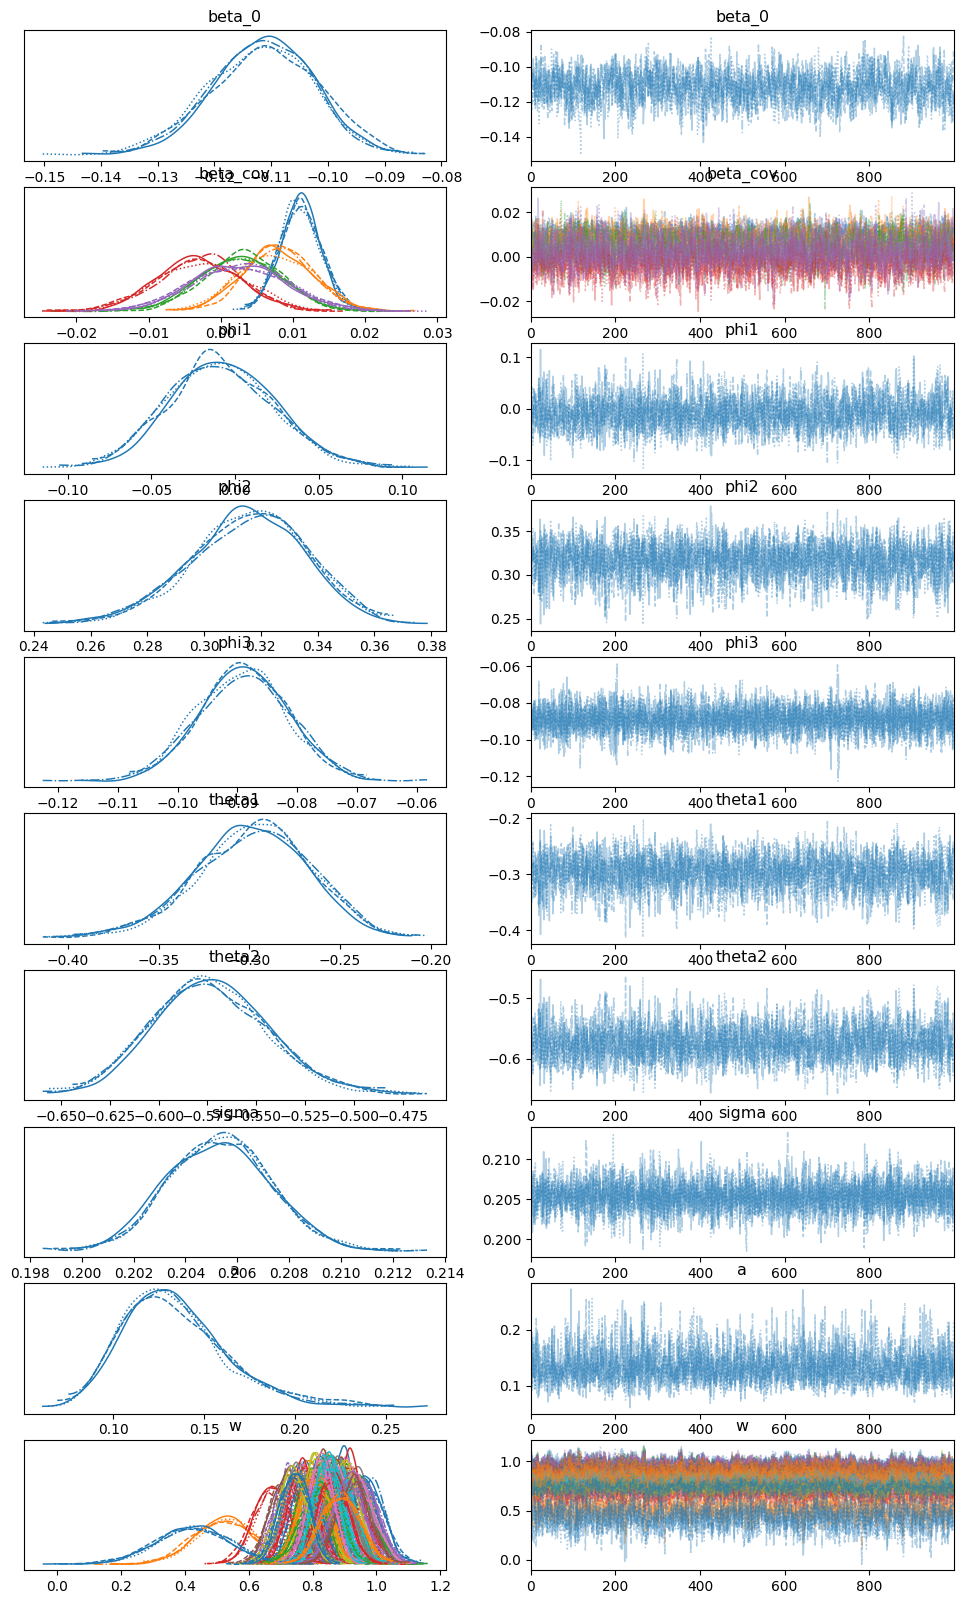

In [14]:
az.plot_trace(arima_az, var_names=["beta_0", "beta_cov", "phi1", "phi2", "phi3", "theta1", "theta2", "sigma","a", "w"])
plt.show()

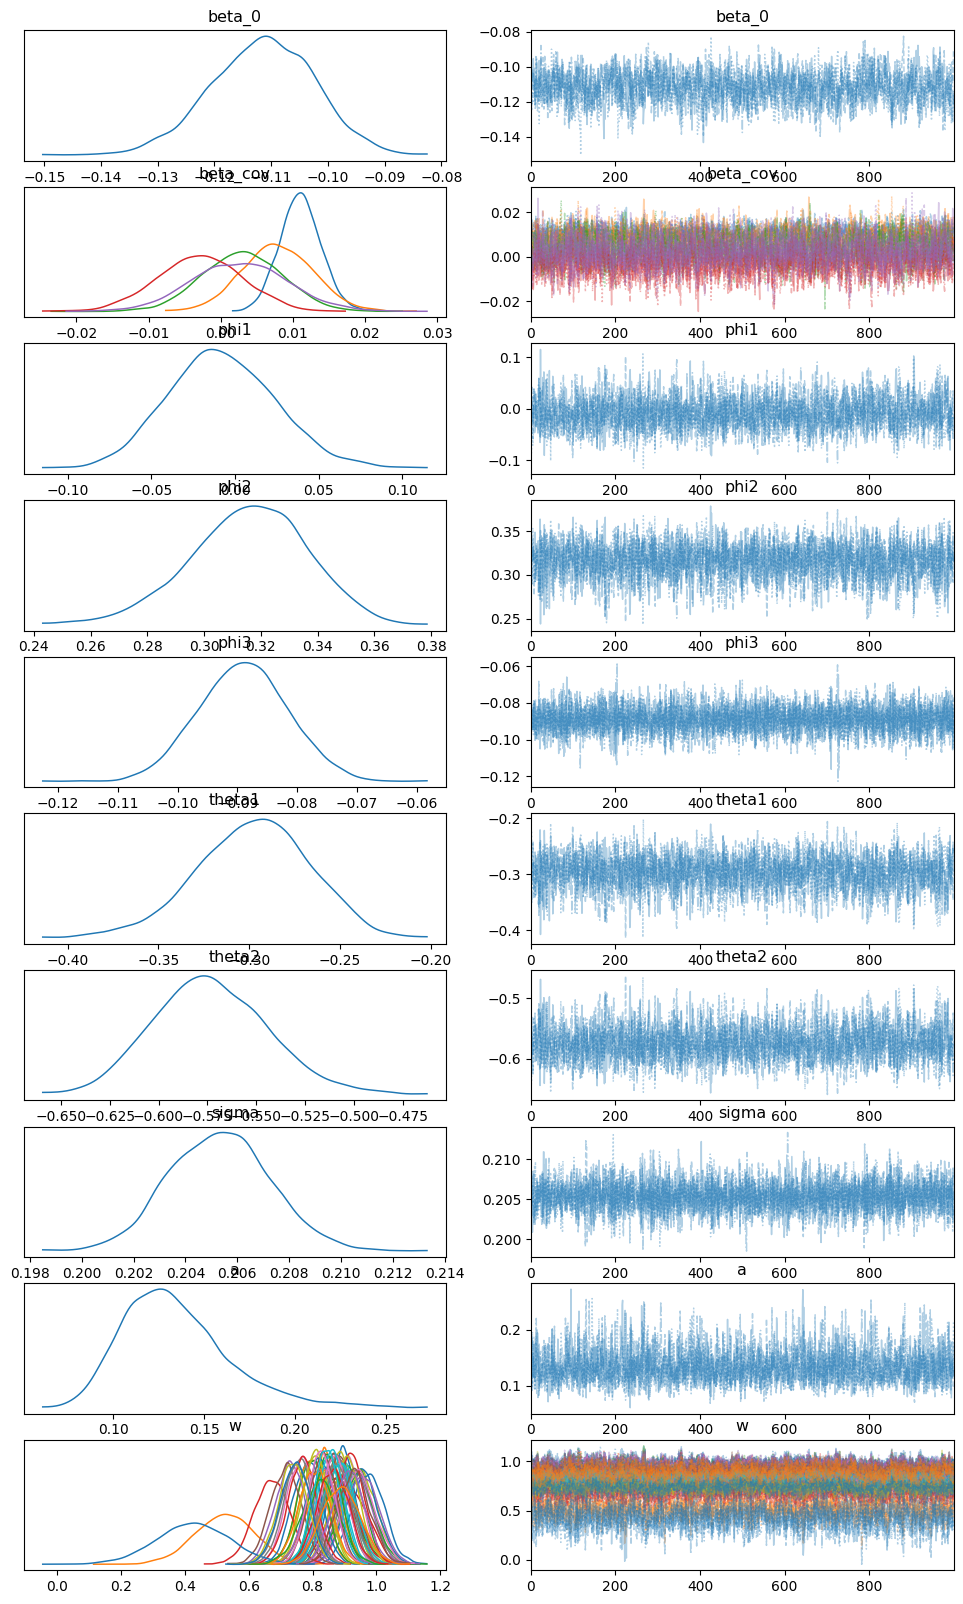

In [15]:
az.plot_trace(arima_az, var_names=["beta_0", "beta_cov", "phi1", "phi2", "phi3", "theta1", "theta2", "sigma","a", "w"], combined = True)
plt.show()

In [16]:
#how many diverging iterations
np.sum(arima_az.sample_stats.diverging)

<xarray.DataArray 'diverging' ()>
array(0)

In [17]:
#to save the model 
import pickle
pickle.dump(fit, open('arima_model_base.p', 'wb'))

In [8]:
#to import the model
import pickle
fit = pickle.load(open('arima_model_base.p', 'rb'))
arima_az = az.from_cmdstanpy(fit)

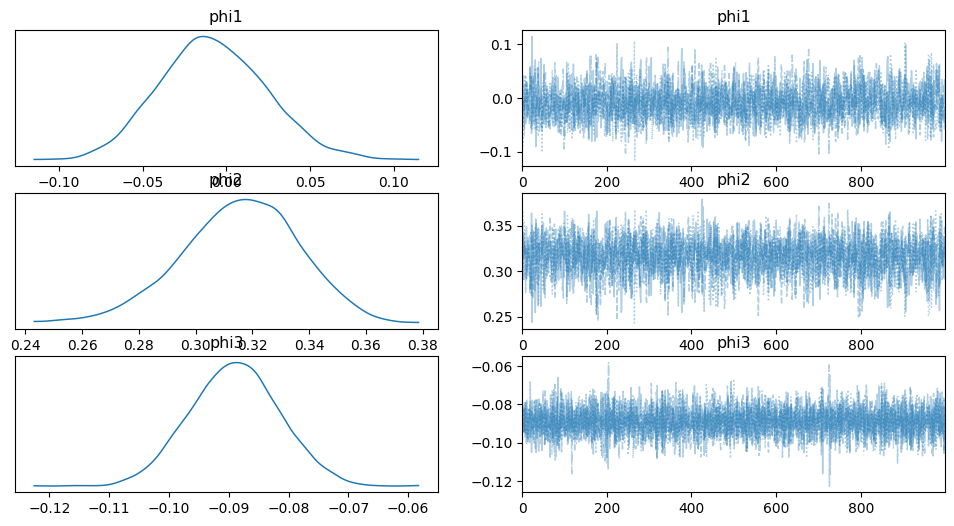

In [7]:
az.plot_trace(arima_az, var_names=["phi1", "phi2", "phi3"], combined = True)
plt.show()

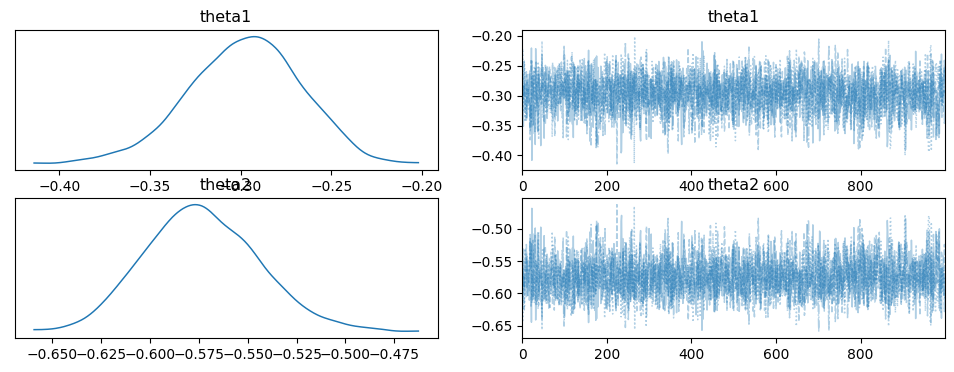

In [8]:
az.plot_trace(arima_az, var_names=["theta1", "theta2"], combined = True)
plt.show()

In [33]:
waic_results = az.waic(arima_az,var_name="log_lik")
print(waic_results)
loo_results = az.loo(arima_az, var_name="log_lik")
print(loo_results)

/Users/indiaermacora/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 22630 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -14742.95   185.76
p_waic      840.94        -

There has been a warning during the calculation. Please check the results.


/Users/indiaermacora/PycharmProjects/pythonProject/venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 22630 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -15036.40   187.09
p_loo     1134.39        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     21290   94.1%
 (0.5, 0.7]   (ok)         455    2.0%
   (0.7, 1]   (bad)        761    3.4%
   (1, Inf)   (very bad)   124    0.5%



-0.1113345
-0.13000287500000002 -0.09448166


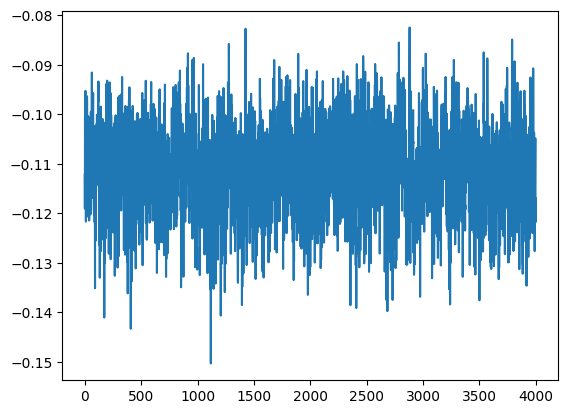

In [88]:
#beta_0
beta_chain = fit.stan_variable(var="beta_0")
plt.plot(beta_chain)
Q1= np.quantile(beta_chain, 0.025)
Q2= np.quantile(beta_chain, 0.5)
Q3= np.quantile(beta_chain, 0.975)

print(Q2)
print(Q1, Q3)

0.01100545
0.00560005125 0.0168847425


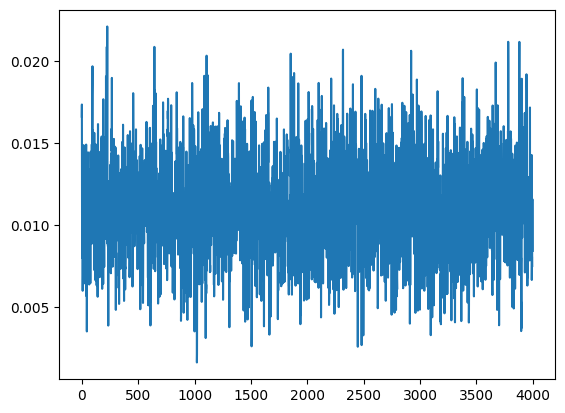

In [89]:
#beta_1 

beta_chain = fit.stan_variable(var="beta_cov")
plt.plot(beta_chain[:,0])
Q1= np.quantile(beta_chain[:,0], 0.025)
Q2= np.quantile(beta_chain[:,0], 0.5)
Q3= np.quantile(beta_chain[:,0], 0.975)

print(Q2)
print(Q1, Q3)

0.00777046
-0.0016062627499999998 0.017568807500000002


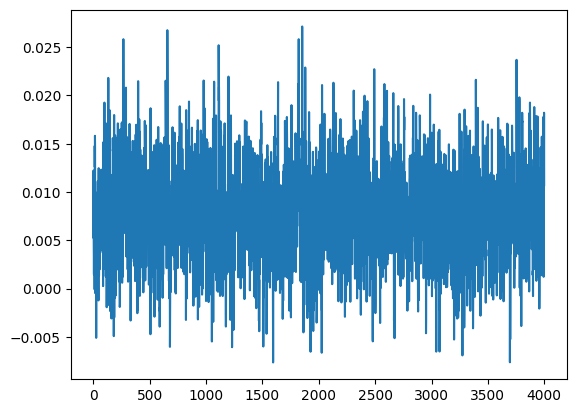

In [104]:
#beta_2 

beta_chain = fit.stan_variable(var="beta_cov")
plt.plot(beta_chain[:,1])
Q1= np.quantile(beta_chain[:,1], 0.025)
Q2= np.quantile(beta_chain[:,1], 0.5)
Q3= np.quantile(beta_chain[:,1], 0.975)

print(Q2)
print(Q1, Q3)

0.002998495
-0.00779213325 0.013878777500000002


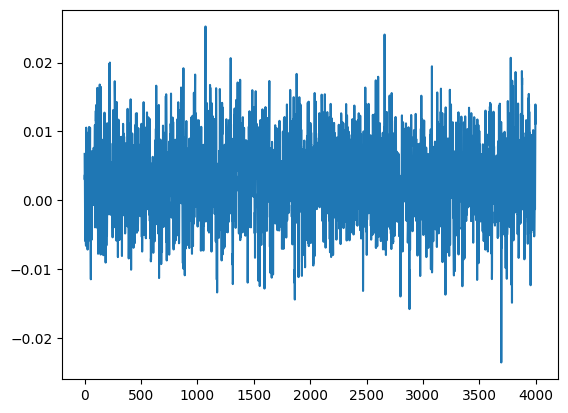

In [91]:
#beta_3 

beta_chain = fit.stan_variable(var="beta_cov")
plt.plot(beta_chain[:,2])
Q1= np.quantile(beta_chain[:,2], 0.025)
Q2= np.quantile(beta_chain[:,2], 0.5)
Q3= np.quantile(beta_chain[:,2], 0.975)

print(Q2)
print(Q1, Q3)

-0.002867935
-0.01463821 0.008377873750000011


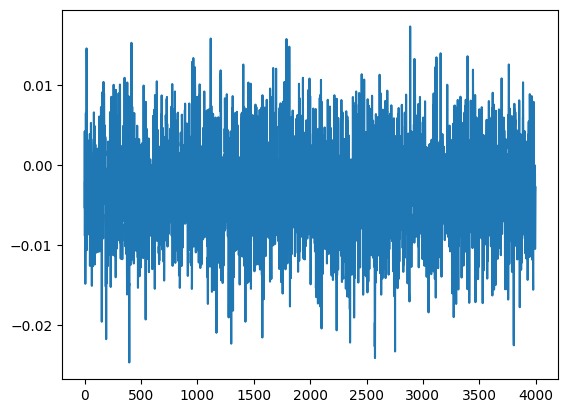

In [92]:
#beta_4 

beta_chain = fit.stan_variable(var="beta_cov")
plt.plot(beta_chain[:,3])
Q1= np.quantile(beta_chain[:,3], 0.025)
Q2= np.quantile(beta_chain[:,3], 0.5)
Q3= np.quantile(beta_chain[:,3], 0.975)

print(Q2)
print(Q1, Q3)

0.0026594799999999997
-0.010322514999999999 0.016093032500000003


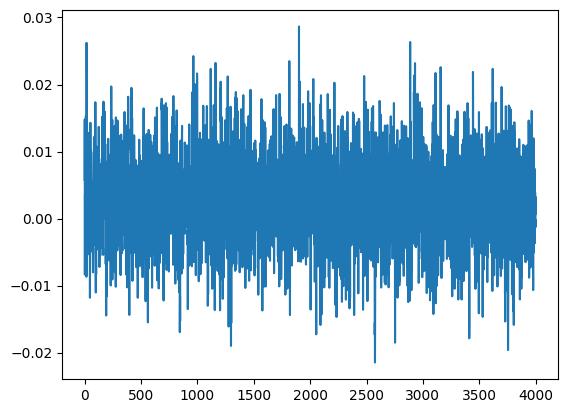

In [93]:
#beta_5 

beta_chain = fit.stan_variable(var="beta_cov")
plt.plot(beta_chain[:,4])
Q1= np.quantile(beta_chain[:,4], 0.025)
Q2= np.quantile(beta_chain[:,4], 0.5)
Q3= np.quantile(beta_chain[:,4], 0.975)

print(Q2)
print(Q1, Q3)

-0.0093262
-0.06731603 0.05672898500000004


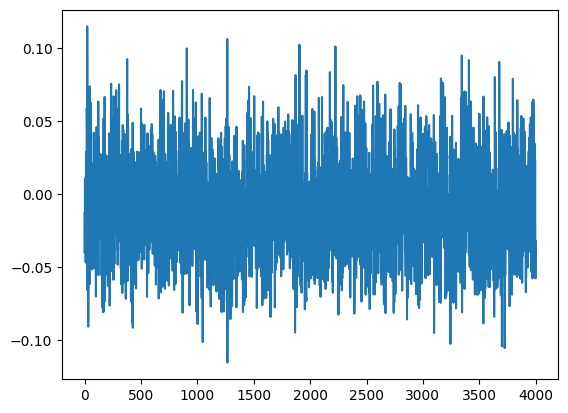

In [94]:
#phi1 

phi1_chain = fit.stan_variable(var="phi1")
plt.plot(phi1_chain)
Q1= np.quantile(phi1_chain, 0.025)
Q2= np.quantile(phi1_chain, 0.5)
Q3= np.quantile(phi1_chain, 0.975)

print(Q2)
print(Q1, Q3)

0.31627249999999996
0.27260432500000004 0.35311580000000004


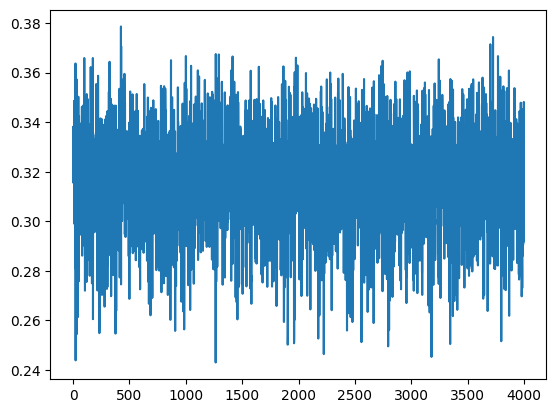

In [95]:
#phi2

phi2_chain = fit.stan_variable(var="phi2")
plt.plot(phi2_chain)
Q1= np.quantile(phi2_chain, 0.025)
Q2= np.quantile(phi2_chain, 0.5)
Q3= np.quantile(phi2_chain, 0.975)

print(Q2)
print(Q1, Q3)

-0.0889295
-0.103519575 -0.074364075


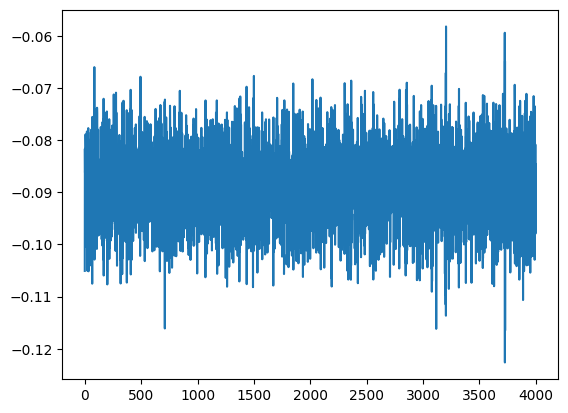

In [96]:
#phi3

phi3_chain = fit.stan_variable(var="phi3")
plt.plot(phi3_chain)
Q1= np.quantile(phi3_chain, 0.025)
Q2= np.quantile(phi3_chain, 0.5)
Q3= np.quantile(phi3_chain, 0.975)

print(Q2)
print(Q1, Q3)

-0.296622
-0.3637435 -0.240833925


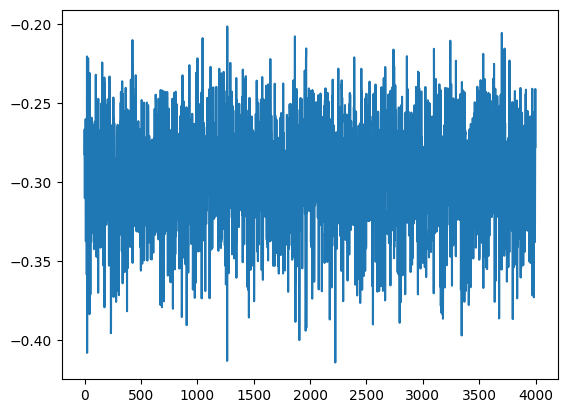

In [97]:
#theta1 

theta1_chain = fit.stan_variable(var="theta1")
plt.plot(theta1_chain)
Q1= np.quantile(theta1_chain, 0.025)
Q2= np.quantile(theta1_chain, 0.5)
Q3= np.quantile(theta1_chain, 0.975)

print(Q2)
print(Q1, Q3)

-0.57462
-0.6269742500000001 -0.511273425


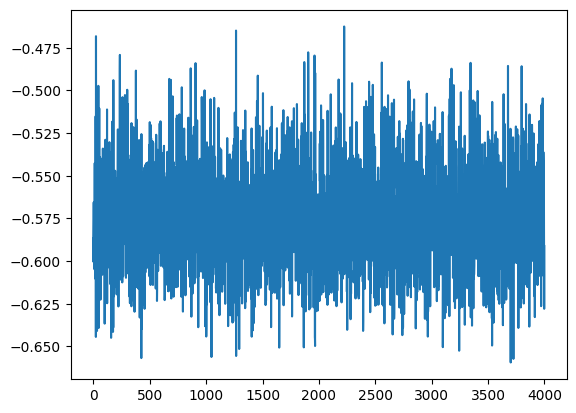

In [98]:
#theta2

theta2_chain = fit.stan_variable(var="theta2")
plt.plot(theta2_chain)
Q1= np.quantile(theta2_chain, 0.025)
Q2= np.quantile(theta2_chain, 0.5)
Q3= np.quantile(theta2_chain, 0.975)

print(Q2)
print(Q1, Q3)

0.20533050000000003
0.201575775 0.20924635


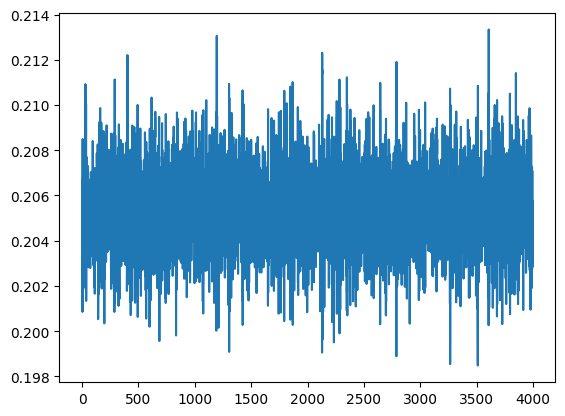

In [99]:
#sigma

sigma_chain = fit.stan_variable(var="sigma")
plt.plot(sigma_chain)
Q1= np.quantile(sigma_chain, 0.025)
Q2= np.quantile(sigma_chain, 0.5)
Q3= np.quantile(sigma_chain, 0.975)

print(Q2)
print(Q1, Q3)

0.1301775
0.0881921525 0.20672822500000004


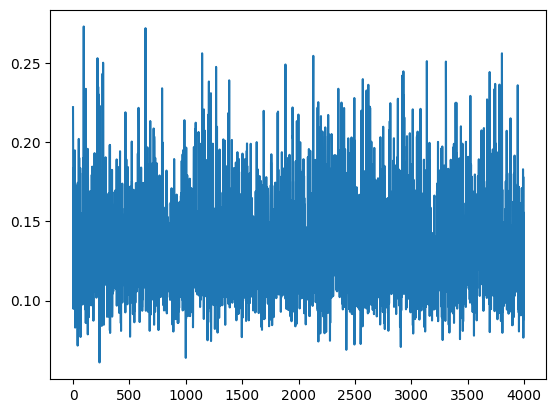

In [100]:
#a

a_chain = fit.stan_variable(var="a")
plt.plot(a_chain)
Q1= np.quantile(a_chain, 0.025)
Q2= np.quantile(a_chain, 0.5)
Q3= np.quantile(a_chain, 0.975)

print(Q2)
print(Q1, Q3)

In [109]:
table = fit.summary(percentiles=(5, 50, 95)) #useless

In [ ]:
#CONFIDENCE INTERVALS 

In [13]:
beta_0 = (fit.stan_variable(var="beta_0")).tolist()
beta_cov = fit.stan_variable(var="beta_cov")
beta_1= (beta_cov[:,0]).tolist()
beta_2= (beta_cov[:,1]).tolist()
beta_3= (beta_cov[:,2]).tolist()
beta_4= (beta_cov[:,3]).tolist()
beta_5= (beta_cov[:,4]).tolist()
phi1 = (fit.stan_variable(var="phi1")).tolist()
phi2 = (fit.stan_variable(var="phi2")).tolist()
phi3 = (fit.stan_variable(var="phi3")).tolist()
theta1 = (fit.stan_variable(var="theta1")).tolist()
theta2 = (fit.stan_variable(var="theta2")).tolist()
sigma = (fit.stan_variable(var="sigma")).tolist()
a = (fit.stan_variable(var="a")).tolist()

In [11]:
import matplotlib.pyplot as plt
import statistics
from math import sqrt


def plot_confidence_interval(x, values, color='#2187bb', horizontal_line_width=0.25):
    median = np.quantile(values, 0.5)

    left = x - horizontal_line_width / 2
    bottom = np.quantile(values, 0.025)
    right = x + horizontal_line_width / 2
    top = np.quantile(values, 0.975)
    
    confidence_interval = [bottom, top]
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, median, 'o', color='#f44336')

    return median, confidence_interval


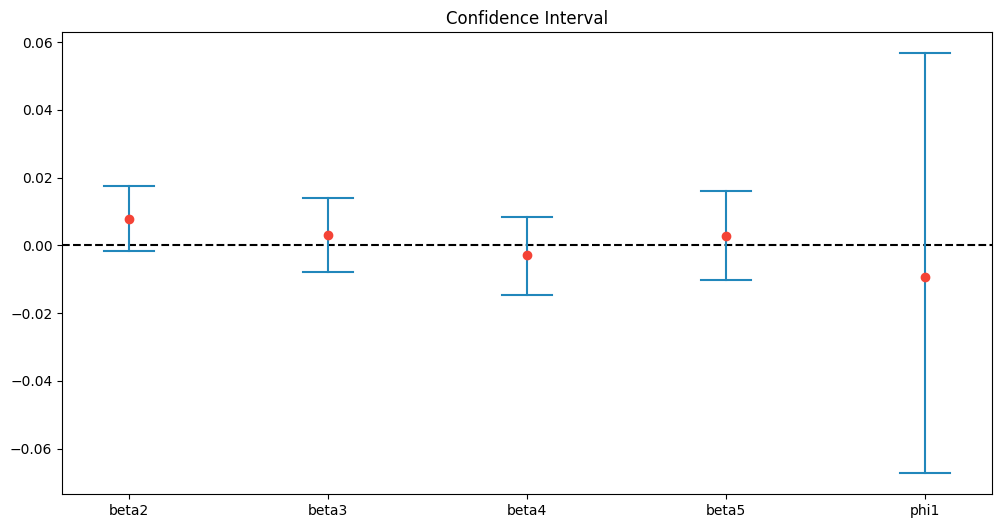

In [9]:
#not significant 
plt.figure(figsize=(12, 6))
plt.xticks([1, 2, 3, 4, 5], ['beta2', 'beta3', 'beta4', 'beta5', 'phi1'])
plt.title('Confidence Interval')
plt.axhline(y=0, color= 'black', linestyle = '--')
plot_confidence_interval(1, beta_2) #indecisa se metterla o no
plot_confidence_interval(2, beta_3)
plot_confidence_interval(3, beta_4)
plot_confidence_interval(4, beta_5)
plot_confidence_interval(5, phi1)

plt.show()

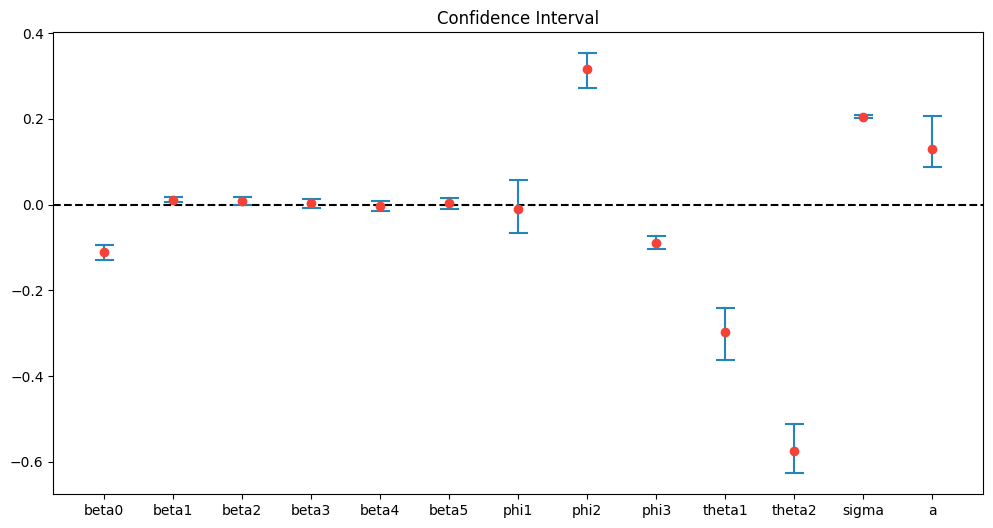

In [14]:
#all
plt.figure(figsize=(12, 6))
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], ['beta0', 'beta1', 'beta2', 'beta3', 'beta4', 'beta5', 'phi1', 'phi2', 'phi3', 'theta1', 'theta2', 'sigma', 'a'])
plt.title('Confidence Interval')
plt.axhline(y=0, color= 'black', linestyle = '--')
plot_confidence_interval(1, beta_0)
plot_confidence_interval(2, beta_1)
plot_confidence_interval(3, beta_2)
plot_confidence_interval(4, beta_3)
plot_confidence_interval(5, beta_4)
plot_confidence_interval(6, beta_5)
plot_confidence_interval(7, phi1)
plot_confidence_interval(8, phi2)
plot_confidence_interval(9, phi3)
plot_confidence_interval(10, theta1)
plot_confidence_interval(11, theta2)
plot_confidence_interval(12, sigma)
plot_confidence_interval(13, a)

plt.show()

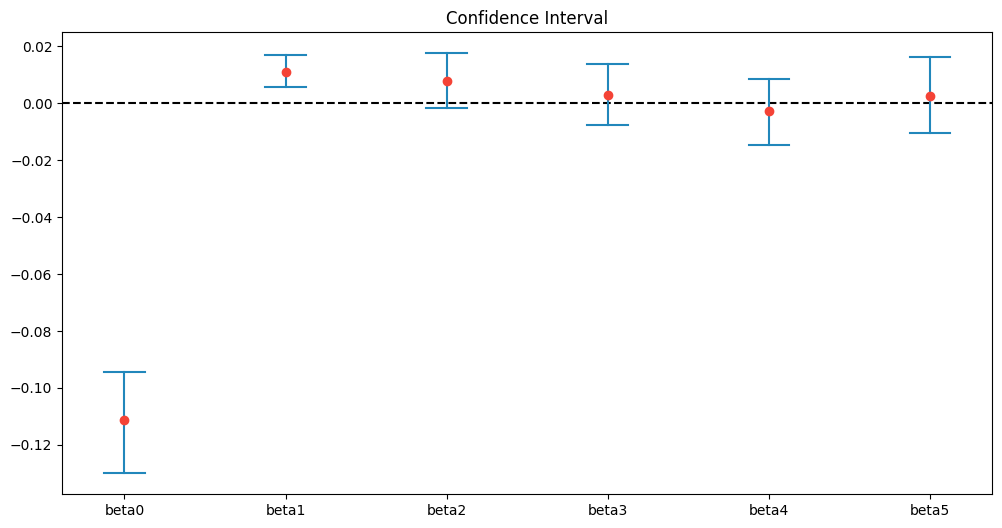

In [27]:
#betas 
plt.figure(figsize=(12, 6))
plt.xticks([1, 2, 3, 4, 5, 6], ['beta0', 'beta1', 'beta2', 'beta3', 'beta4', 'beta5'])
plt.title('Confidence Interval')
plt.axhline(y=0, color= 'black', linestyle = '--')
plot_confidence_interval(1, beta_0) 
plot_confidence_interval(2, beta_1) 
plot_confidence_interval(3, beta_2)
plot_confidence_interval(4, beta_3)
plot_confidence_interval(5, beta_4)
plot_confidence_interval(6, beta_5)

plt.show()

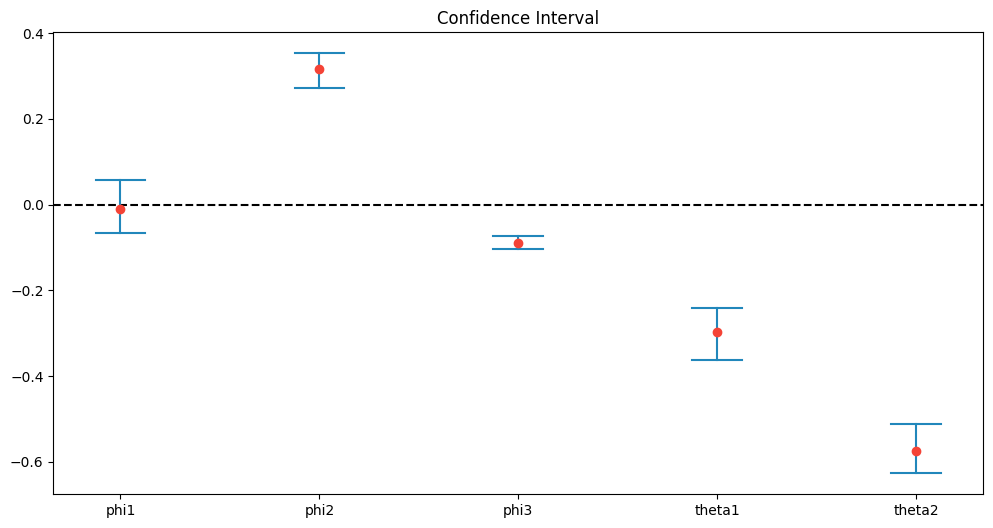

In [23]:
#arima coefficients 
plt.figure(figsize=(12, 6))
plt.xticks([1, 2, 3, 4, 5], ['phi1', 'phi2', 'phi3', 'theta1', 'theta2'])
plt.title('Confidence Interval')
plt.axhline(y=0, color= 'black', linestyle = '--')
plot_confidence_interval(1, phi1)
plot_confidence_interval(2, phi2)
plot_confidence_interval(3, phi3)
plot_confidence_interval(4, theta1)
plot_confidence_interval(5, theta2)

plt.show()

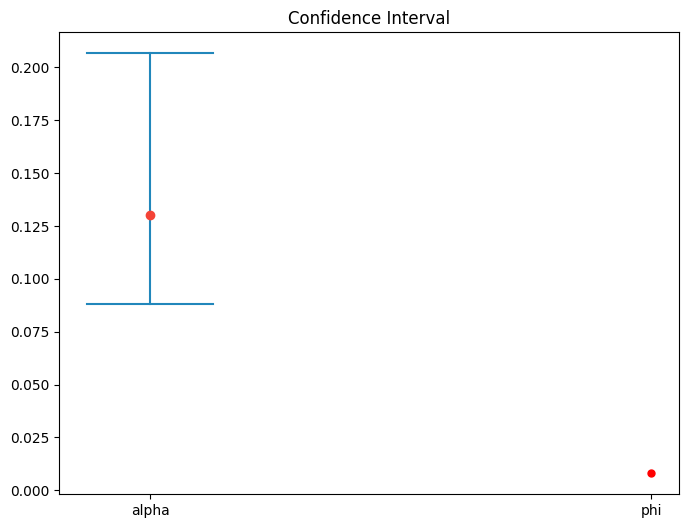

In [23]:
#spatial residuals 
plt.figure(figsize=(8, 6))
plt.xticks([1, 2], ['alpha', 'phi'])
plt.title('Confidence Interval')
#plt.axhline(y=0, color= 'black', linestyle = '--')
plot_confidence_interval(1, a)
plt.plot(2,0.008, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="red")
plt.show()